In [2]:
import tensorflow as tf
import folium
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd

from utils import *

2024-01-28 12:52:26.930878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 12:52:26.930914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
model = tf.keras.models.load_model('./models/optimise/best_tuned.keras')

2024-01-28 12:52:28.516672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-28 12:52:28.516783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 12:52:28.516815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-28 12:52:28.516843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-28 12:52:28.516869: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [4]:
df = pd.read_csv("./data/test/test_quat_final_400.csv")
X = df.iloc[:, 0:-5]
y = df.iloc[:, -1]
X = reshape_for_conv(X, 6, 400)

Reshaping input for convolution...


In [5]:
predictions = model.predict(X)
predictions = list(map(lambda x: round(x[0]), predictions))

In [6]:
coords = [(row.latitude, row.longitude) for _, row in df.iterrows()]
labels = [row.label for _, row in df.iterrows()]
speeds = [row.speed for _, row in df.iterrows()]

In [7]:
df["altitude_delta"] = df["altitude"].diff().fillna(0.0000000001)
df["altitude_delta"] = df["altitude_delta"].abs()
df["altitude_delta"] += 1
df["altitude_delta"] = df["altitude_delta"].replace(to_replace=0.0000, method='ffill')
df["altitude_delta"] = df["altitude_delta"].clip(0,6)
#df["altitude_delta"] = np.log2(df["altitude_delta"])
df["altitude_delta"] = df["altitude_delta"] / df["altitude_delta"].max()
altitudes = [row.altitude_delta for _, row in df.iterrows()]

In [11]:
def rgb2hex(rgb):
    rgb = [int(256*x) for x in rgb]
    r, g, b = ['%02x' % x for x in rgb]
    return f"#{r}{g}{b}"
color_mapper = cm.ScalarMappable(cmap=cm.cividis)

In [12]:
rgb_values = [c[:3] for c in color_mapper.to_rgba(speeds)] # keep rgb and drop the "a" column
colors = [rgb2hex(rgb) for rgb in rgb_values]

In [13]:
speed_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=14) 

# Add the points to the map (red for lift, green for piste)
for point, pred, label, color in zip(coords, predictions, labels, colors):
    # condition for showing up
	if label == 0:
		continue
	
	color = color #"#fc0303" if pred == 0 else "#03fc18"

	if pred == 0:
		folium.Circle(location=point,
							radius=15.0,
							fill=True,
    						opacity=1,
    						fill_opacity=1,
							color=color).add_to(speed_map)
	else:
		folium.Circle(location=point,
							radius=6.0,
    						fill=True,
    						opacity=0.2,
    						fill_opacity=0.2,
							color=color).add_to(speed_map)
    
speed_map.save("map.html")

In [14]:
color_mapper_alt = cm.ScalarMappable(cmap=cm.cividis, norm=Normalize(vmin=0, vmax=1))
rgb_values_alt = [c[:3] for c in color_mapper_alt.to_rgba(altitudes)] # keep rgb and drop the "a" column
colors_alt = [rgb2hex(rgb) for rgb in rgb_values_alt]

In [ ]:
alt_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=14) 

# Add the points to the map (red for lift, green for piste)
for point, pred, label, color in zip(coords, predictions, labels, colors_alt):
    # condition for showing up
	if label == 0:
		continue
	
	color = color #"#fc0303" if pred == 0 else "#03fc18"

	if pred == 0:
		folium.Circle(location=point,
							radius=15.0,
							fill=True,
    						opacity=1,
    						fill_opacity=1,
							color=color).add_to(alt_map)
	else:
		folium.Circle(location=point,
							radius=6.0,
    						fill=True,
    						opacity=0.2,
    						fill_opacity=0.2,
							color=color).add_to(alt_map)
    
alt_map.save("map.html")

In [120]:
# Compare lift and flat skiing sections

lift = ("2023-12-28 14:48:30.801705700", "2023-12-28 14:48:40.687788000")
wrong_piste = ("2023-12-28 15:03:05.962933800", "2023-12-28 15:03:15.580831200")
pred_piste = ("2023-12-28 15:22:10.394476300", "2023-12-28 15:22:19.952965600")

In [4]:
import seaborn as sns
import pandas as pd

In [48]:
df_raw = pd.read_csv("./data/test/labelled.csv")

In [121]:
df_lift = df_raw[df_raw["time"] >= lift[0]]
df_lift = df_lift[df_lift["time"] <= lift[1]]

df_wrong_piste = df_raw[df_raw["time"] >= wrong_piste[0]]
df_wrong_piste = df_wrong_piste[df_wrong_piste["time"] <= wrong_piste[1]]

df_pred_piste = df_raw[df_raw["time"] >= pred_piste[0]]
df_pred_piste = df_pred_piste[df_pred_piste["time"] <= pred_piste[1]]

In [51]:
print(df_wrong_piste.shape, df_lift.shape, df_pred_piste.shape)

(274, 21) (274, 21) (274, 21)


In [79]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

[(-15.0, 15.0)]

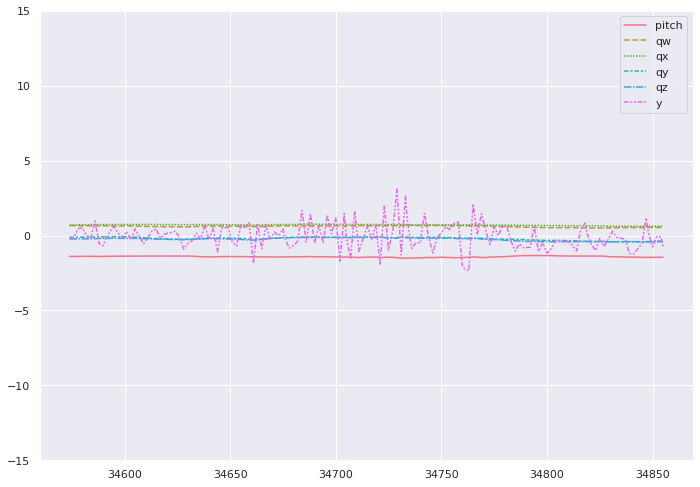

In [122]:
ax = sns.lineplot(
	data=df_lift[['pitch', 'qw', 'qx', 'qy', 'qz', 'y']],
	palette="husl"
)
ax.set(ylim=(-15, 15))

[(-15.0, 15.0)]

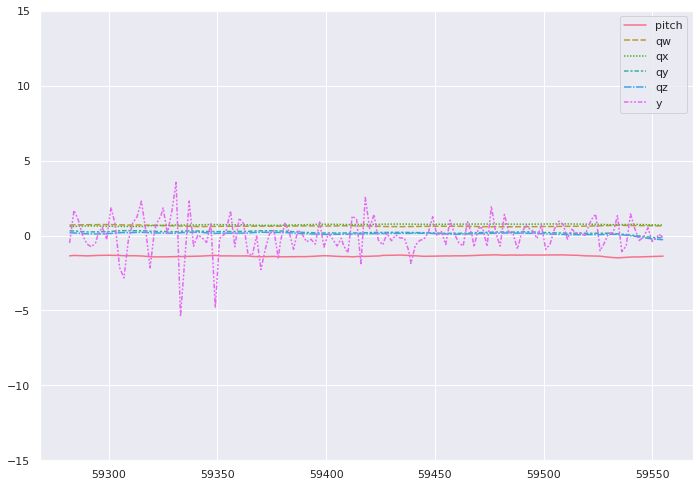

In [71]:
ax = sns.lineplot(
	data=df_wrong_piste[['pitch', 'qw', 'qx', 'qy', 'qz', 'y']],
	palette="husl"
)
ax.set(ylim=(-15, 15))

[(-15.0, 15.0)]

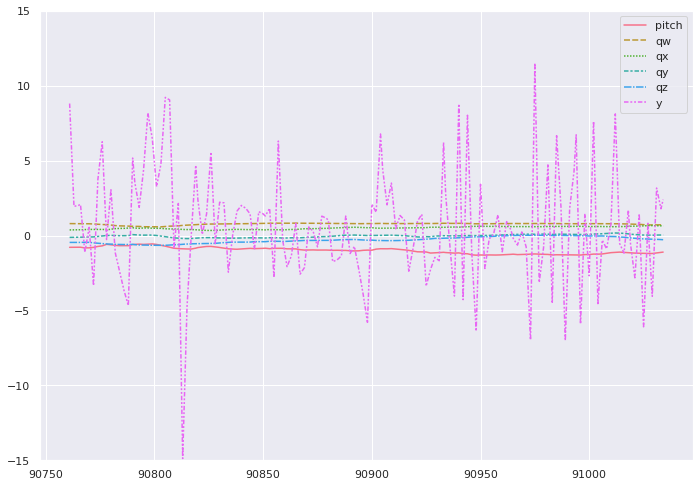

In [72]:
ax = sns.lineplot(
	data=df_pred_piste[['pitch', 'qw', 'qx', 'qy', 'qz', 'y']],
	palette="husl"
)
ax.set(ylim=(-15, 15))